In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

df = pd.read_csv("unified_genotypes_preprocessed_final_v2 - unified_genotypes_preprocessed_final_v2.csv")

In [2]:
def preprocess(df):
    df = df.drop(columns=['patient_id', 'risk'])
    # df = df.drop(columns=[col for col in df.columns if col.startswith('chrX') or col.startswith('chrY')])
    return df

df = preprocess(df)
df.head()

,group,chr1_826893,chr1_941119,chr1_952421,chr1_953259,chr1_953279,chr1_961945,chr1_962184,chr1_979847,chr1_1013466,...,chrX_143629567,chrX_145823364,chrX_150762633,chrX_151700795,chrX_152850288,chrX_153776089,chrX_154412069,chrX_156023167,chrX_156023436,vaccination
0,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,0,1,1,1,1,0.0
1,0,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,0,0,0.0
2,1,1,1,1,1,1,1,1,0,0,...,2,2,2,2,2,2,2,1,1,0.0
3,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,0,0,0.0
4,1,0,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,1,1,0.0


In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['group'])
y = df['group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

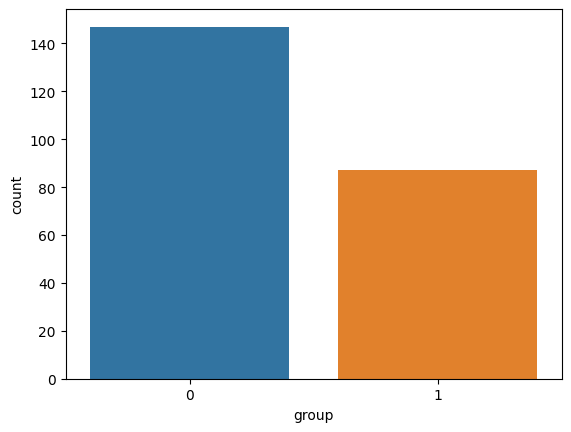

In [4]:
import seaborn as sns

sns.countplot(x=y, hue=y, palette='tab10', legend=False)
plt.show()

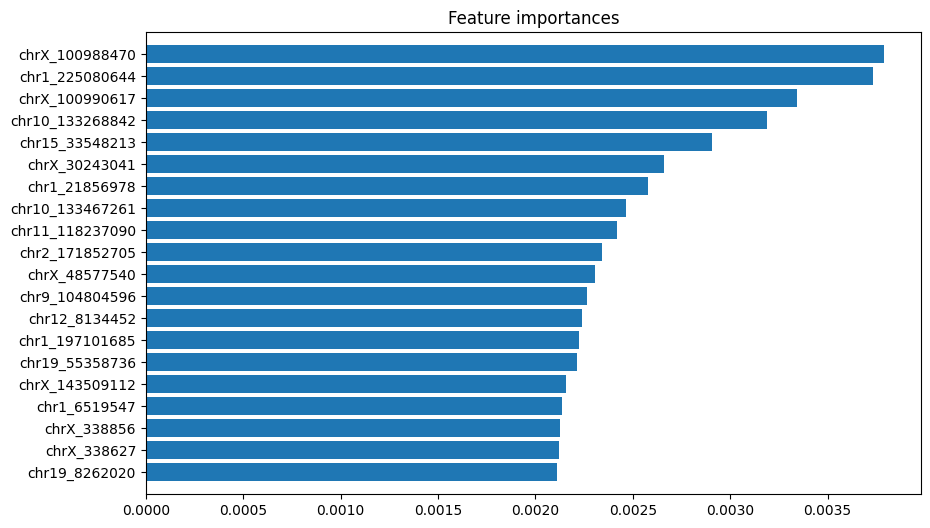

In [5]:
from sklearn.ensemble import RandomForestClassifier

def plot_feature_importances(X_train, n_features_to_plot=20):
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1][:n_features_to_plot]

    plt.figure(figsize=(10, 6))
    plt.title("Feature importances")
    plt.barh(range(n_features_to_plot), importances[indices][::-1], align="center")
    plt.yticks(range(n_features_to_plot), X_train.columns[indices][::-1])
    plt.ylim([-1, n_features_to_plot])
    plt.show()

plot_feature_importances(X_train)

In [6]:
def feature_selection(X_train, X_test, n_features=20, verbose=True):
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1][:n_features]
    if verbose:
        print(f"Selected features ({n_features}):")
        print(*X_train.columns[indices].tolist(), sep=", ")

    X_train = X_train.iloc[:, indices]
    X_test = X_test.iloc[:, indices]
    return X_train, X_test

X_train, X_test = feature_selection(X_train, X_test, n_features=12)

Selected features (12):
chrX_100988470, chr1_225080644, chrX_100990617, chr10_133268842, chr15_33548213, chrX_30243041, chr1_21856978, chr10_133467261, chr11_118237090, chr2_171852705, chrX_48577540, chr9_104804596


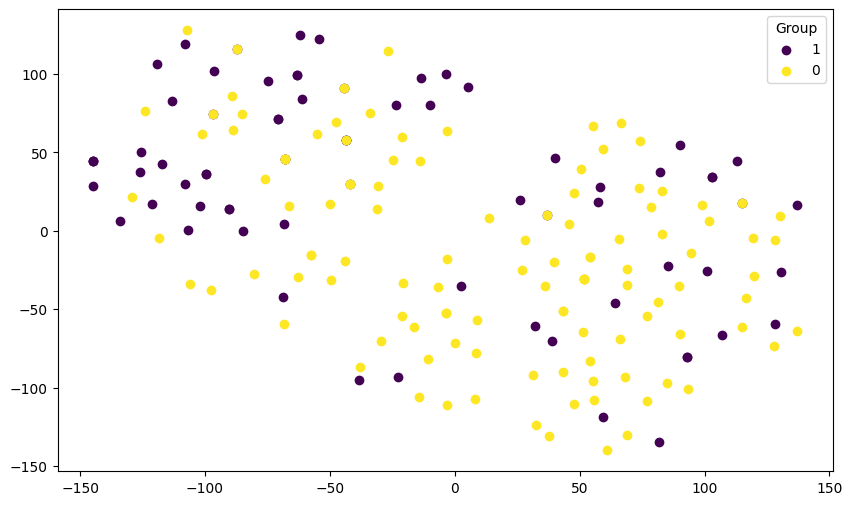

In [7]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def plot_tsne(X_train, y_train):
    X_scaled = StandardScaler().fit_transform(X_train)
    X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)
    
    plt.figure(figsize=(10, 6))
    unique_labels = y_train.unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
    for i, label in enumerate(unique_labels):
        X_label = X_embedded[y_train == label]
        plt.scatter(X_label[:, 0], X_label[:, 1], color=colors[i], label=label)
    plt.legend(title='Group')
    plt.show()

plot_tsne(X_train, y_train)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42))
])

pipe.fit(X_train, y_train)
base_pipe = pipe
print(f"Baseline model score: {base_pipe.score(X_test, y_test):.4f}")

Baseline model score: 0.7447


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

param_grid = {
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1]
}

grid = GridSearchCV(pipe, param_grid, cv=LeaveOneOut(), n_jobs=-1)  # Cuidado com o LeaveOneOut e o número de features/hiperparâmetros
grid.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10, 100],
                         'svc__gamma': [0.001, 0.01, 0.1, 1],
                         'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid']})

Best model considering F1: Baseline


,Accuracy,Precision,Recall,F1
Baseline,0.744681,0.666667,0.5000,0.571429
Tuned,0.702128,0.583333,0.4375,0.500000


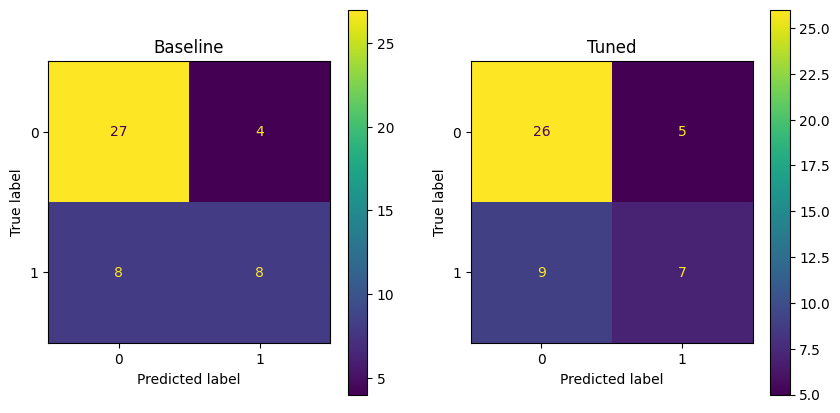

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display

def create_df_metrics(baseline, tuned, sort_by='F1'):
    baseline_y_pred = baseline.predict(X_test)
    tuned_y_pred = tuned.predict(X_test)

    metrics = {
        'Accuracy': [accuracy_score(y_test, baseline_y_pred), accuracy_score(y_test, tuned_y_pred)],
        'Precision': [precision_score(y_test, baseline_y_pred), precision_score(y_test, tuned_y_pred)],
        'Recall': [recall_score(y_test, baseline_y_pred), recall_score(y_test, tuned_y_pred)],
        'F1': [f1_score(y_test, baseline_y_pred), f1_score(y_test, tuned_y_pred)]
    }

    df = pd.DataFrame(metrics, index=['Baseline', 'Tuned']).sort_values(by=sort_by, axis=0, ascending=False)
    print(f'Best model considering {sort_by}: {df.index[0]}')
    return df

def plot_confusion_matrix(model, subplot_pos, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    ax = plt.subplot(subplot_pos)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=ax)
    ax.title.set_text(title)

df_metrics = create_df_metrics(base_pipe, grid)
display(df_metrics)

plt.figure(figsize=(10, 5))
plot_confusion_matrix(base_pipe, 121, 'Baseline')
plot_confusion_matrix(grid, 122, 'Tuned')
plt.show()